This is a starter project about 3D abstract shape classification, using PointNet.

Create by Siyang Zhang, on Jan 22, 2023.

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.utils import shuffle
import pickle
from tensorflow import keras
from keras import layers
from matplotlib import pyplot as plt

Part 1: Generating synthetic 3D data
I create function to create point clouds of 7 different types of 3D shape, including: ball, cube, cylinder, cone, pyramid, ring, and torus.

In [2]:
NUM_SAMPLES = 2048


def generate_dataset(num=1000, save=False):
    inputs = []
    labels = []
    for i, _ in enumerate(range(num)):
        inputs.append(generate_ball())
        inputs.append(generate_cube())
        inputs.append(generate_cylinder())
        inputs.append(generate_cone())
        inputs.append(generate_pyramid())
        inputs.append(generate_ring())
        inputs.append(generate_torus())
        labels.extend([0, 1, 2, 3, 4, 5, 6])
        print('\rGenerating data: {}/{}'.format(i + 1, num), end='')
    print()

    inputs = np.array(inputs)
    labels = np.array(labels)
    print('inputs.shape: ', inputs.shape)
    print('labels.shape: ', labels.shape)
    inputs, labels = shuffle(inputs, labels)

    if save:
        data = {'inputs': inputs, 'labels': labels}
        with open(f'data3dshape_{NUM_SAMPLES}_{num * len(lb)}.p', 'wb') as f:
            pickle.dump(data, f)
    return inputs, labels


def generate_ball():
    """
    Generate a ball in 3D space
    """

    result = []
    R = np.random.uniform(0.5, 1.0)
    for _ in range(NUM_SAMPLES):
        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.random.uniform(0, np.pi)
        r = np.random.uniform(0, R)
        # r = R
        x = r * np.sin(phi) * np.cos(theta)
        y = r * np.sin(phi) * np.sin(theta)
        z = r * np.cos(phi)
        result.append([x, y, z])

    return np.array(result)


def generate_cube():

    result = []
    for _ in range(NUM_SAMPLES):
        x = np.random.uniform(-1, 1)
        y = np.random.uniform(-1, 1)
        z = np.random.uniform(-1, 1)
        result.append([x, y, z])

    return np.array(result)


def generate_cylinder():

    result = []
    r = np.random.uniform(0.1, 0.5)
    h = np.random.uniform(0.1, 5.0)

    for _ in range(NUM_SAMPLES):
        theta = np.random.uniform(0, 2 * np.pi)
        a = np.random.uniform(0, r)
        z = np.random.uniform(0, h)
        x = a * np.cos(theta)
        y = a * np.sin(theta)
        result.append([x, y, z])

    return np.array(result)


def generate_cone():
    result = []
    r = np.random.uniform(0.1, 0.5)
    h = np.random.uniform(0.1, 5.0)

    for _ in range(NUM_SAMPLES):
        z = np.random.uniform(0, h)
        rh = (h - z) * r / h
        a = np.random.uniform(0, rh)
        # a = rh
        theta = np.random.uniform(0, 2 * np.pi)
        x = a * np.cos(theta)
        y = a * np.sin(theta)
        result.append([x, y, z])

    return np.array(result)


def generate_pyramid():
    result = []
    a = np.random.uniform(0.1, 0.5)
    h = np.random.uniform(0.1, 5.0)

    for _ in range(NUM_SAMPLES):
        x = np.random.uniform(-a, a)
        y = np.random.uniform(-a, a)
        z = np.random.uniform(0, h)

        xh = (h - z) * x / h
        yh = (h - z) * y / h

        result.append([xh, yh, z])

    return np.array(result)


def generate_ring():
    result = []
    r = np.random.uniform(2.0, 3.0)
    R = np.random.uniform(4.0, 5.0)

    h = np.random.uniform(0.1, 1.0)

    for _ in range(NUM_SAMPLES):

        theta = np.random.uniform(0, 2 * np.pi)
        a = np.random.uniform(r, R)
        x = a * np.cos(theta)
        y = a * np.sin(theta)
        z = np.random.uniform(-h, h)

        result.append([x, y, z])

    return np.array(result)


def generate_torus():
    result = []
    r = np.random.uniform(1.0, 3.0)
    R = np.random.uniform(4.0, 5.0)

    for _ in range(NUM_SAMPLES):

        theta = np.random.uniform(0, 2 * np.pi)
        phi = np.random.uniform(0, 2 * np.pi)
        a = np.random.uniform(0, r)
        # a = r
        x = (R + a * np.cos(phi)) * np.cos(theta)
        y = (R + a * np.cos(phi)) * np.sin(theta)
        z = a * np.sin(phi)

        result.append([x, y, z])

    return np.array(result)

Visualization of Shape

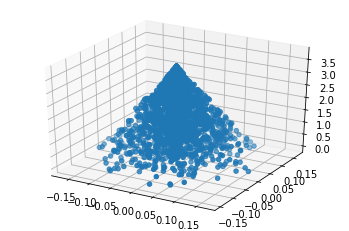

In [3]:
obj3d = generate_cone()
ax = plt.axes(projection='3d')
ax.scatter(obj3d[:, 0], obj3d[:, 1], obj3d[:, 2])
plt.show()

Part 2: PointNet Model

based on the paper: https://arxiv.org/abs/1612.00593

Reference: https://keras.io/examples/vision/pointnet/

In [10]:
# Regularizer
class OrthogonalRegularizer(keras.regularizers.Regularizer):

    def __init__(self, n_features, l2reg=0.001):
        self.n_features = n_features
        self.l2reg = l2reg
        self.eye = tf.eye(n_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.n_features, self.n_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.n_features, self.n_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))


# The Tnet class for featurization.
class Tnet(tf.keras.layers.Layer):

    def __init__(self, n_features):
        super(Tnet, self).__init__()
        self.n_features = n_features
        self.bias = tf.constant_initializer(0.0)
        self.reg = OrthogonalRegularizer(n_features)
        self.conv1 = tf.keras.Sequential([
            layers.Conv1D(32, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv1D(64, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv1D(512, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.global_max_pooling = layers.GlobalMaxPooling1D()

        self.dense1 = tf.keras.Sequential([
            layers.Dense(256),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.dense2 = tf.keras.Sequential([
            layers.Dense(128),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.dense3 = tf.keras.Sequential([
            layers.Dense(self.n_features * self.n_features,
                            kernel_regularizer=self.reg,
                            bias_initializer=self.bias),
            layers.Reshape((self.n_features, self.n_features))
        ])

        self.dt = layers.Dot(axes=(2, 1))

    def call(self, inputs):

        x = self.conv1(inputs)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.global_max_pooling(x)

        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.dt([inputs, x])

# Main Model
class PointNet(tf.keras.Model):

    def __init__(self, num_class):
        super(PointNet, self).__init__()
        self.tnet1 = Tnet(3)
        self.tnet2 = Tnet(64)

        self.conv1 = tf.keras.Sequential([
            layers.Conv1D(64, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.conv2 = tf.keras.Sequential([
            layers.Conv1D(64, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.conv3 = tf.keras.Sequential([
            layers.Conv1D(64, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])

        self.max_pool = layers.GlobalMaxPooling1D()

        self.conv4 = tf.keras.Sequential([
            layers.Conv1D(128, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.conv5 = tf.keras.Sequential([
            layers.Conv1D(1024, 1, padding='valid'),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])

        self.dense1 = tf.keras.Sequential([
            layers.Dense(512),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])
        self.dense2 = tf.keras.Sequential([
            layers.Dense(256),
            layers.BatchNormalization(momentum=0.0),
            layers.Activation('relu')
        ])

        self.dropout = layers.Dropout(0.3)
        self.classifier = layers.Dense(num_class, activation='softmax')

    def call(self, inputs):
        x = self.tnet1(inputs)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.tnet2(x)

        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = self.max_pool(x)

        x = self.dense1(x)
        x = self.dense2(x)

        x = self.dropout(x)
        x = self.classifier(x)

        return x

Prepare for data and build model:

In [29]:
# for each category, generate 500 point clouds. Thus in total 3500 pieces of point clouds.
inputs, labels = generate_dataset(500)

BATCH_SIZE = 100

print(inputs.shape)
train_inputs = inputs[:-100]
train_labels = labels[:-100]
test_inputs = inputs[-100:]
test_labels = labels[-100:]

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))



Generating data: 500/500
inputs.shape:  (3500, 2048, 3)
labels.shape:  (3500,)
(3500, 2048, 3)


Build Model

In [30]:
train_dataset = train_dataset.shuffle(len(train_inputs)).batch(BATCH_SIZE)
test_dataset = test_dataset.shuffle(len(test_inputs)).batch(BATCH_SIZE)
model = PointNet(num_class=7)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [31]:
model.fit(train_dataset, epochs=20, batch_size=BATCH_SIZE, validation_data=test_dataset)

Epoch 1/20
34/34 [==============================] - 28s 661ms/step - loss: 1082.3124 - accuracy: 0.6406 - val_loss: 1043.1254 - val_accuracy: 0.7100
Epoch 2/20
34/34 [==============================] - 22s 642ms/step - loss: 992.4476 - accuracy: 0.7079 - val_loss: 939.5298 - val_accuracy: 0.6800
Epoch 3/20
34/34 [==============================] - 22s 635ms/step - loss: 895.2019 - accuracy: 0.7479 - val_loss: 853.1039 - val_accuracy: 0.8300
Epoch 4/20
34/34 [==============================] - 22s 636ms/step - loss: 823.9199 - accuracy: 0.8268 - val_loss: 798.6360 - val_accuracy: 0.8500
Epoch 5/20
34/34 [==============================] - 22s 647ms/step - loss: 784.3256 - accuracy: 0.8585 - val_loss: 773.1559 - val_accuracy: 0.8600
Epoch 6/20
34/34 [==============================] - 22s 638ms/step - loss: 767.7516 - accuracy: 0.8815 - val_loss: 763.9000 - val_accuracy: 0.8300
Epoch 7/20
34/34 [==============================] - 22s 634ms/step - loss: 761.5938 - accuracy: 0.8874 - val_loss: 7

In [35]:
cone = generate_cone()
torus = generate_torus()

cone = tf.convert_to_tensor(cone)
cone = tf.expand_dims(cone, 0)
print(cone.shape)
probs = model(cone)
print(probs)
print(tf.argmax(probs[0]))

torus = tf.convert_to_tensor(torus)
torus = tf.expand_dims(torus, 0)
print(torus.shape)
probs = model(torus)
print(probs)
print(tf.argmax(probs[0]))





(1, 2048, 3)
tf.Tensor(
[[2.5514164e-04 1.0589239e-04 3.7941757e-01 6.1618108e-01 3.2864586e-03
  3.1815239e-04 4.3573332e-04]], shape=(1, 7), dtype=float32)
tf.Tensor(3, shape=(), dtype=int64)
(1, 2048, 3)
tf.Tensor(
[[4.0183142e-05 7.6681581e-06 2.6240823e-05 9.5175972e-05 1.9414618e-04
  3.9674153e-04 9.9923992e-01]], shape=(1, 7), dtype=float32)
tf.Tensor(6, shape=(), dtype=int64)
